In [1]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import numpy as np
import os

import sys
sys.path.append('../')

from data_processing.process_data import process_data, get_single_df, add_rolling_stats

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from feature_engine.selection import SmartCorrelatedSelection, DropConstantFeatures, DropDuplicateFeatures, DropFeatures, DropCorrelatedFeatures, SelectBySingleFeaturePerformance, RecursiveFeatureAddition
from feature_engine.outliers import Winsorizer

## Data loading

In [2]:
datasets = process_data()

X, y = get_single_df()

In [3]:
model = lgb.LGBMClassifier()

In [4]:
def test_train_split(df_X, df_y):
    size_train = int(df_X.shape[0]*0.8)
    size_test = df_X.shape[0] - size_train
    x_train = df_X[:size_train]
    y_train = df_y[:size_train].anomaly
    x_test = df_X[-size_test:]
    y_test = df_y[-size_test:].anomaly
    return x_train, y_train, x_test, y_test

In [5]:
x_train, y_train, x_test, y_test = test_train_split(X, y)

## Base model

In [6]:
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],eval_metric=['rmse', 'l2', 'loggloss', 'mape'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6745, number of negative: 21034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1789
[LightGBM] [Info] Number of data points in the train set: 27779, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242809 -> initscore=-1.137339
[LightGBM] [Info] Start training from score -1.137339


LGBMClassifier()

In [7]:
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.9515
Testing accuracy 0.7378


In [8]:
yhat = model.predict(x_test)

accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat)
print('F1 score: %f' % f1)

Accuracy: 0.737797
Precision: 0.605929
Recall: 0.817647
F1 score: 0.696044


In [9]:
conf_matrix = metrics.confusion_matrix(y_test, yhat)

TN, FP, FN, TP = conf_matrix.ravel()

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate FAR false alarm rate
FPR = FP/(FP+TN)
# False negative rate MAR missing alarm rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(f'False Alarm Rate: {FPR}')
print(f'Missing Alarm Rate: {FNR}')

False Alarm Rate: 0.30853242320819113
Missing Alarm Rate: 0.18235294117647058


In [10]:
print(metrics.classification_report(y_test,model.predict(x_test)))

              precision    recall  f1-score   support

         0.0       0.87      0.69      0.77      4395
         1.0       0.61      0.82      0.70      2550

    accuracy                           0.74      6945
   macro avg       0.74      0.75      0.73      6945
weighted avg       0.77      0.74      0.74      6945



## Apply steps on datasets

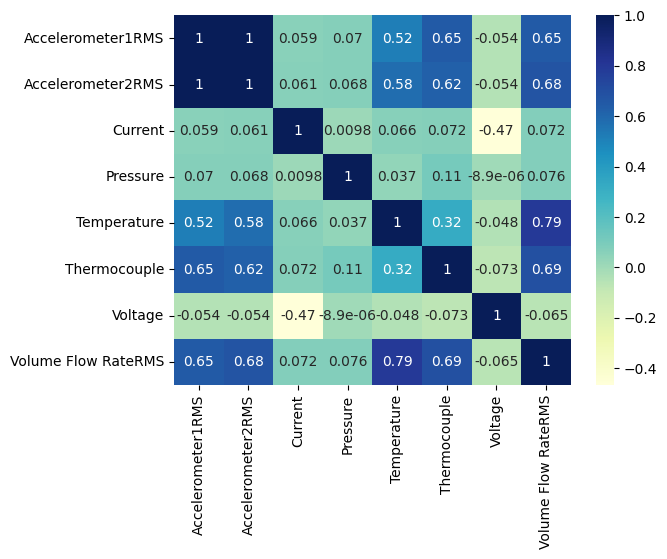

In [11]:
corr_plot = sns.heatmap(x_train.corr(), cmap="YlGnBu", annot=True) 
plt.show()

__Add rolling stats__

In [12]:
x_train = add_rolling_stats(x_train, '1min', x_train.columns)
x_test = add_rolling_stats(x_test, '1min', x_test.columns)

/Users/ronibendom/Projects/MLOps/data_processing/process_data.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_rolling_mean"] = df[f"{col}"].rolling(time_diff).mean()
/Users/ronibendom/Projects/MLOps/data_processing/process_data.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_rolling_mean"] = df[f"{col}"].rolling(time_diff).mean()
/Users/ronibendom/Projects/MLOps/data_processing/process_data.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [13]:
x_train

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,Accelerometer1RMS_rolling_mean,Accelerometer2RMS_rolling_mean,...,Voltage_rolling_std,Volume Flow RateRMS_rolling_std,Accelerometer1RMS_rolling_kurtosis,Accelerometer2RMS_rolling_kurtosis,Current_rolling_kurtosis,Pressure_rolling_kurtosis,Temperature_rolling_kurtosis,Thermocouple_rolling_kurtosis,Voltage_rolling_kurtosis,Volume Flow RateRMS_rolling_kurtosis
datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-08 13:30:47,0.206030,0.277924,1.81019,0.382638,90.1740,26.7760,228.208,121.664,0.206030,0.277924,...,0.680944,0.237588,-4.918349,-0.967473,0.718897,4.000000,2.938416,3.010799,2.395044,-1.419771
2020-02-08 13:30:48,0.204366,0.275727,2.66317,-0.273216,90.2836,26.7760,227.245,122.000,0.205198,0.276826,...,0.680944,0.237588,-4.918349,-0.967473,0.718897,4.000000,2.938416,3.010799,2.395044,-1.419771
2020-02-08 13:30:49,0.206103,0.278526,2.63758,0.382638,89.8666,26.7821,237.872,122.000,0.205500,0.277392,...,5.877264,0.193990,-4.918349,-0.967473,0.718897,4.000000,2.938416,3.010799,2.395044,-1.419771
2020-02-08 13:30:51,0.204775,0.276948,2.32851,0.382638,90.2192,26.7773,230.422,121.338,0.205319,0.277281,...,4.811020,0.317353,-4.918349,-0.967473,0.718897,4.000000,2.938416,3.010799,2.395044,-1.419771
2020-02-08 13:30:52,0.206052,0.278141,2.53422,0.382638,90.1449,26.7773,219.454,121.664,0.205465,0.277453,...,6.612877,0.277545,-2.537611,0.167838,2.205415,5.000000,3.163396,3.724871,1.411602,-0.716979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-09 12:47:32,0.026915,0.039263,1.30224,0.054711,70.1619,24.9044,225.022,29.000,0.027514,0.040581,...,9.782549,0.341642,-0.346725,-0.857047,-1.078382,0.346981,-0.095292,-0.565817,0.255974,5.607707
2020-03-09 12:47:33,0.028247,0.041516,1.49579,0.054711,70.2642,24.9151,241.563,29.000,0.027515,0.040594,...,9.921371,0.341675,-0.337512,-0.902735,-1.097805,0.538965,-0.229496,-0.482843,0.115768,5.606957
2020-03-09 12:47:34,0.026902,0.040274,1.25504,0.054711,70.1373,24.9125,229.521,29.000,0.027502,0.040574,...,9.820220,0.318064,-0.445257,-0.880122,-1.111539,0.538965,-0.045082,-0.681958,0.227126,7.214196


__Winsorizer__

In [14]:
wz = Winsorizer(capping_method='quantiles', tail='both', fold=3)

In [15]:
wz.fit(x_train)
x_train = wz.transform(x_train)
x_test = wz.transform(x_test)

__Standard scaler__

In [16]:
sc = StandardScaler()

In [17]:
# sc.fit(x_train)
# x_train = sc.transform(x_train)
# x_test = sc.transform(x_test)

__PCA__

In [18]:
pca = PCA(n_components='mle', svd_solver='full')

In [19]:
# pca.fit(x_train)
# x_train = pca.transform(x_train)
# x_test = pca.transform(x_test)

__RFE based on SVM__

In [20]:
estimator = SVR(kernel="linear")
rfe = RFE(estimator, n_features_to_select=5, step=1)

In [21]:
# rfe.fit(x_train, y_train)
# x_train = rfe.transform(x_train)
# x_test = rfe.transform(x_test)

__Feature selection by single feature performance using random forest estimator__

In [22]:
sfp = SelectBySingleFeaturePerformance(
                    RandomForestClassifier(random_state=42),
                    cv=2)

In [23]:
sfp.fit(x_train, y_train)
x_train = sfp.transform(x_train)
x_test = sfp.transform(x_test)

__Feature selection by information value__

In [24]:
rfa = RecursiveFeatureAddition(RandomForestClassifier(random_state=42), cv=2)

In [25]:
# rfa.fit(x_train, y_train)
# x_train = rfa.transform(x_train)
# x_test = rfa.transform(x_test)

__Smart correlated features__

In [26]:
scs = SmartCorrelatedSelection(threshold=0.8)

In [27]:
# print(f'valve 1 dataset number of columns: {x_train.shape[1]}')

# scs.fit(x_train)
# x_train = scs.transform(x_train)
# x_test = scs.transform(x_test)

# print('********************* Drop correlated columns *********************')
# print(f'valve 1 dataset number of columns: {x_train.shape[1]}')

## Retest model

In [28]:
x_train, y_train, x_test, y_test = test_train_split(X, y)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],eval_metric=['rmse', 'l2', 'loggloss', 'mape'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6745, number of negative: 21034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1789
[LightGBM] [Info] Number of data points in the train set: 27779, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242809 -> initscore=-1.137339
[LightGBM] [Info] Start training from score -1.137339


LGBMClassifier()

In [29]:
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.9515
Testing accuracy 0.7378


In [30]:
yhat = model.predict(x_test)

accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat)
print('F1 score: %f' % f1)

Accuracy: 0.737797
Precision: 0.605929
Recall: 0.817647
F1 score: 0.696044


In [31]:
conf_matrix = metrics.confusion_matrix(y_test, yhat)

TN, FP, FN, TP = conf_matrix.ravel()

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate FAR false alarm rate
FPR = FP/(FP+TN)
# False negative rate MAR missing alarm rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(f'False Alarm Rate: {FPR}')
print(f'Missing Alarm Rate: {FNR}')

False Alarm Rate: 0.30853242320819113
Missing Alarm Rate: 0.18235294117647058


In [32]:
print(metrics.classification_report(y_test,model.predict(x_test)))

              precision    recall  f1-score   support

         0.0       0.87      0.69      0.77      4395
         1.0       0.61      0.82      0.70      2550

    accuracy                           0.74      6945
   macro avg       0.74      0.75      0.73      6945
weighted avg       0.77      0.74      0.74      6945

